
# Probabilistic Backpropagation (PBP) - PyTorch Demo

This notebook implements a simplified Probabilistic Backpropagation (PBP) training loop for a small MLP on a synthetic regression task.  
It follows the assumed density filtering flavor described by Hernandez-Lobato & Adams (2015), with forward propagation of moments and
backward updates of the per-weight Gaussian posterior parameters using the moment matching rules.

**What you get here**
- A factorized Gaussian posterior over each weight and bias: q(w)=N(m,v).
- Forward pass that propagates means/variances through linear layers and ReLU using closed-form moment formulas.
- Per-datum updates of (m, v) using the PBP moment matching rules:
  m_new = m + v * dlogZ/dm,  v_new = v - v^2 * ( (dlogZ/dm)^2 - 2*dlogZ/dv ).
- Approximate marginal likelihood log Z using a Gaussian approximation to the Student-t integral that appears when
  marginalizing the output noise (as done in the paper).
- Gamma priors for the observation noise precision with cheap ADF updates once per example.
- Training and inference on toy data plus visualization of predictive mean and uncertainty bands.


In [16]:
import math
from typing import List, Tuple

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

torch.set_default_dtype(torch.float64)
device = torch.device("cuda")
seed = 42
torch.manual_seed(seed)

# Standard normal helpers
normal = torch.distributions.Normal(
    loc=torch.tensor(0.0, dtype=torch.float64),
    scale=torch.tensor(1.0, dtype=torch.float64),
)


def phi(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(-0.5 * x * x) / math.sqrt(2.0 * math.pi)


def Phi(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def relu_moments(
    m: torch.Tensor, v: torch.Tensor, eps: float = 1e-12
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Closed-form mean & variance of ReLU(X) for X ~ N(m, v).
    v = torch.clamp(v, min=eps)
    sigma = torch.sqrt(v)
    alpha = m / sigma
    alpha_eval = torch.clamp(alpha, min=-10.0, max=10.0)
    pdf = phi(alpha_eval)
    cdf = Phi(alpha_eval)

    mean = sigma * pdf + m * cdf
    second_moment = (v + m * m) * cdf + m * sigma * pdf
    var = torch.clamp(second_moment - mean * mean, min=eps)
    return mean, var


class ProbLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        d = self.in_features + 1  # +1 bias
        h = self.out_features
        scale = 1.0 / math.sqrt(d)
        self.m = nn.Parameter(scale * torch.randn(h, d, dtype=torch.float64))
        self.v = nn.Parameter(0.5 * torch.ones(h, d, dtype=torch.float64))


class PBPNet(nn.Module):
    def __init__(self, layer_sizes: List[int]):
        super().__init__()
        self.layers: List[ProbLinear] = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(ProbLinear(layer_sizes[i], layer_sizes[i + 1]))

    def forward_moments(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        assert x.dim() == 2 and x.shape[0] >= 1
        batch = x.shape[0]

        mz = torch.cat(
            [x, torch.ones(batch, 1, dtype=torch.float64)], dim=1
        )  # (B, D+1)
        vz = torch.zeros_like(mz)

        for li, layer in enumerate(self.layers):
            d = layer.in_features + 1
            scale = 1.0 / math.sqrt(d)

            ma = (mz @ layer.m.t()) * scale  # (B, H)
            term1 = vz @ (layer.m**2).t()
            term2 = (mz**2) @ layer.v.t()
            term3 = vz @ layer.v.t()
            va = (term1 + term2 + term3) * (scale**2)

            is_last = li == len(self.layers) - 1
            if not is_last:
                mb, vb = relu_moments(ma, va)
                mz = torch.cat([mb, torch.ones(batch, 1, dtype=torch.float64)], dim=1)
                vz = torch.cat([vb, torch.zeros(batch, 1, dtype=torch.float64)], dim=1)
            else:
                mz = ma
                vz = va

        return mz, vz


def logZ_gaussian_likelihood(
    y: torch.Tensor,
    mz: torch.Tensor,
    vz: torch.Tensor,
    alpha_g: torch.Tensor,
    beta_g: torch.Tensor,
    eps: float = 1e-12,
) -> torch.Tensor:
    # Z ~ N(y | mz, beta_g/(alpha_g-1) + vz)
    alpha_g = torch.clamp(alpha_g, min=1.0 + 1e-6)
    sigma2_eff = beta_g / (alpha_g - 1.0) + vz
    sigma2_eff = torch.clamp(sigma2_eff, min=eps)
    return (
        -0.5 * ((y - mz) ** 2) / sigma2_eff
        - 0.5 * torch.log(2.0 * math.pi * sigma2_eff)
    ).squeeze(-1)


def gamma_adf_update_from_Z(
    logZ: torch.Tensor,
    logZ1: torch.Tensor,
    logZ2: torch.Tensor,
    alpha_old: torch.Tensor,
    beta_old: torch.Tensor,
    clamp_eps: float = 1e-9,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Implements equations analogous to (9) and (10) using Z, Z1, Z2.
    r1 = torch.exp(logZ1 - logZ)  # Z1 / Z
    r2 = torch.exp(logZ2 - logZ)  # Z2 / Z

    term_alpha = (r2 / (r1 * r1)) * ((alpha_old + 1.0) / alpha_old)
    denom_alpha = torch.clamp(term_alpha - 1.0, min=1e-12)
    alpha_new = 1.0 / denom_alpha

    termA = r2 / r1 * ((alpha_old + 1.0) / beta_old)
    termB = r1 * (alpha_old / beta_old)
    denom_beta = torch.clamp(termA - termB, min=clamp_eps)
    beta_new = 1.0 / denom_beta

    alpha_new = torch.clamp(alpha_new, min=1.0 + 1e-6, max=1e6)
    beta_new = torch.clamp(beta_new, min=clamp_eps, max=1e9)
    return alpha_new.detach(), beta_new.detach()


def single_datapoint_adf_step(
    net: PBPNet,
    x: torch.Tensor,
    y: torch.Tensor,
    alpha_g: torch.Tensor,
    beta_g: torch.Tensor,
    step_clip: float = 1.0,
) -> Tuple[torch.Tensor, torch.Tensor]:
    for layer in net.layers:
        layer.m.requires_grad_(True)
        layer.v.requires_grad_(True)

    mz, vz = net.forward_moments(x[None, :])  # (1,1)
    logZ = logZ_gaussian_likelihood(y[None, None], mz, vz, alpha_g, beta_g).mean()

    logZ1 = logZ_gaussian_likelihood(
        y[None, None], mz, vz, alpha_g + 1.0, beta_g
    ).mean()
    logZ2 = logZ_gaussian_likelihood(
        y[None, None], mz, vz, alpha_g + 2.0, beta_g
    ).mean()

    for p in net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    logZ.backward()

    for layer in net.layers:
        gm = layer.m.grad
        gv = layer.v.grad

        if step_clip is not None:
            gm = torch.clamp(gm, min=-step_clip, max=step_clip)
            gv = torch.clamp(gv, min=-step_clip, max=step_clip)

        m = layer.m
        v = torch.clamp(layer.v, min=1e-10, max=1e3)

        m_new = m + v * gm
        v_new = v - (v * v) * (gm * gm - 2.0 * gv)
        v_new = torch.clamp(v_new, min=1e-10, max=1e3)
        m_new = m_new.detach()
        v_new = v_new.detach()

        with torch.no_grad():
            layer.m.copy_(m_new)
            layer.v.copy_(v_new)

    alpha_g, beta_g = gamma_adf_update_from_Z(
        logZ.detach(), logZ1.detach(), logZ2.detach(), alpha_g, beta_g
    )

    for layer in net.layers:
        layer.m.grad = None
        layer.v.grad = None

    return alpha_g, beta_g


def prior_refresh_epoch(
    net: PBPNet, alpha_l: torch.Tensor, beta_l: torch.Tensor, n_refresh: int = 1
):
    alpha_l = torch.clamp(alpha_l, min=1.0 + 1e-6)
    for _ in range(n_refresh):
        s2 = beta_l / (alpha_l - 1.0)
        s2_1 = beta_l / (alpha_l)  # alpha+1
        s2_2 = beta_l / (alpha_l + 1.0)  # alpha+2

        Z_acc = 0.0
        Z1_acc = 0.0
        Z2_acc = 0.0
        n_tot = 0

        for layer in net.layers:
            m = layer.m
            v = torch.clamp(layer.v, min=1e-12)

            m_tmp = m.detach().clone().requires_grad_(True)
            v_tmp = v.detach().clone().requires_grad_(True)

            sigma2 = s2 + v_tmp
            lp = -0.5 * (m_tmp**2) / sigma2 - 0.5 * torch.log(2.0 * math.pi * sigma2)
            logZ_prior = lp.sum()

            for p in [m_tmp, v_tmp]:
                if p.grad is not None:
                    p.grad.zero_()
            logZ_prior.backward()

            gm = m_tmp.grad
            gv = v_tmp.grad

            m_new = m + v * gm
            v_new = v - (v * v) * (gm * gm - 2.0 * gv)
            v_new = torch.clamp(v_new, min=1e-12, max=1e3)
            m_new = m_new.detach()
            v_new = v_new.detach()

            with torch.no_grad():
                layer.m.copy_(m_new)
                layer.v.copy_(v_new)

            def sum_logZ_given_s2(s2_local: torch.Tensor) -> torch.Tensor:
                sigma2_local = s2_local + v
                lp_local = -0.5 * (m**2) / sigma2_local - 0.5 * torch.log(
                    2.0 * math.pi * sigma2_local
                )
                return lp_local.sum()

            Z_acc += sum_logZ_given_s2(s2).detach()
            Z1_acc += sum_logZ_given_s2(s2_1).detach()
            Z2_acc += sum_logZ_given_s2(s2_2).detach()
            n_tot += m.numel()

        logZ_avg = Z_acc / max(n_tot, 1)
        logZ1_avg = Z1_acc / max(n_tot, 1)
        logZ2_avg = Z2_acc / max(n_tot, 1)

        alpha_l, beta_l = gamma_adf_update_from_Z(
            logZ_avg, logZ1_avg, logZ2_avg, alpha_l, beta_l
        )

    return alpha_l.detach(), beta_l.detach()

In [ ]:
# Synthetic regression data


def make_data(n_train=1000, n_test=200, noise_std=0.3, seed=0):
    torch.manual_seed(seed)
    X = torch.linspace(-4.5, 4.5, n_train + n_test).unsqueeze(-1)
    def f(x):
        return (
            1.5 * torch.sin(1.2 * x)
            + 0.3 * x
            + 0.5 * torch.sin(2.3 * x)
        )
    y_clean = f(X)
    y = y_clean + noise_std * torch.randn_like(y_clean)

    idx = torch.randperm(X.shape[0])
    X = X[idx]
    y = y[idx]

    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]
    return X_train, y_train, X_test, y_test, f


X_train, y_train, X_test, y_test, f_true = make_data()
X_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [22]:
# Build network
net = PBPNet([1, 64, 1])

# Gamma priors (weakly-informative, as in the paper's defaults)
alpha_g = torch.tensor(6.0, dtype=torch.float64)  # noise precision
beta_g = torch.tensor(6.0, dtype=torch.float64)

alpha_l = torch.tensor(6.0, dtype=torch.float64)  # weight precision
beta_l = torch.tensor(6.0, dtype=torch.float64)

# Training
epochs = 100
for epoch in range(1, epochs + 1):
    order = torch.randperm(X_train.shape[0])
    for idx in order.tolist():
        x = X_train[idx]
        y = y_train[idx]
        alpha_g, beta_g = single_datapoint_adf_step(
            net, x, y, alpha_g, beta_g, step_clip=2.0
        )

    # Prior refresh once per epoch
    alpha_l, beta_l = prior_refresh_epoch(net, alpha_l, beta_l, n_refresh=1)

    with torch.no_grad():
        mz, vz = net.forward_moments(X_test)
        sigma2_eff = beta_g / (alpha_g - 1.0) + vz
        rmse = torch.sqrt(torch.mean((mz.squeeze() - y_test.squeeze()) ** 2)).item()
        nlpd = (
            0.5 * torch.log(2 * math.pi * sigma2_eff.squeeze())
            + 0.5 * ((y_test.squeeze() - mz.squeeze()) ** 2) / sigma2_eff.squeeze()
        )
        nlpd = nlpd.mean().item()
    print(
        f"Epoch {epoch:02d} | test RMSE: {rmse:.4f} | test NLPD: {nlpd:.4f} | alpha_g={alpha_g.item():.2f}, beta_g={beta_g.item():.2f}"
    )

Epoch 01 | test RMSE: 0.6523 | test NLPD: 1.1101 | alpha_g=403.42, beta_g=307.97
Epoch 02 | test RMSE: 0.4691 | test NLPD: 0.8439 | alpha_g=871.82, beta_g=464.74
Epoch 03 | test RMSE: 0.4041 | test NLPD: 0.7039 | alpha_g=1351.45, beta_g=568.25
Epoch 04 | test RMSE: 0.3734 | test NLPD: 0.6163 | alpha_g=1834.93, beta_g=652.40
Epoch 05 | test RMSE: 0.3590 | test NLPD: 0.5593 | alpha_g=2320.25, beta_g=727.59
Epoch 06 | test RMSE: 0.3486 | test NLPD: 0.5158 | alpha_g=2806.92, beta_g=797.97
Epoch 07 | test RMSE: 0.3486 | test NLPD: 0.4912 | alpha_g=3294.74, beta_g=864.90
Epoch 08 | test RMSE: 0.3366 | test NLPD: 0.4563 | alpha_g=3783.35, beta_g=929.72
Epoch 09 | test RMSE: 0.3370 | test NLPD: 0.4409 | alpha_g=4272.79, beta_g=992.97
Epoch 10 | test RMSE: 0.3298 | test NLPD: 0.4175 | alpha_g=4762.71, beta_g=1055.32
Epoch 11 | test RMSE: 0.3265 | test NLPD: 0.4014 | alpha_g=5253.23, beta_g=1116.80
Epoch 12 | test RMSE: 0.3253 | test NLPD: 0.3898 | alpha_g=5744.35, beta_g=1177.34
Epoch 13 | test

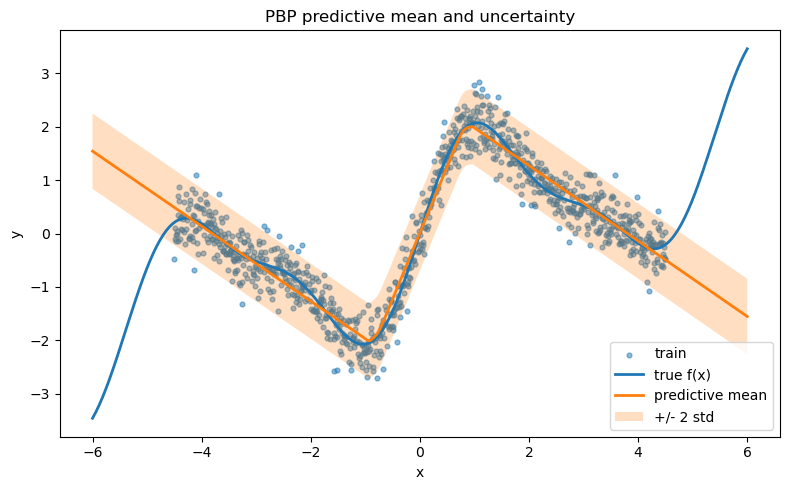

'pbp_uncertainty.png'

In [23]:
# Inference and plot
with torch.no_grad():
    X_plot = torch.linspace(-6.0, 6.0, 400).unsqueeze(-1)
    mz, vz = net.forward_moments(X_plot)
    pred_mean = mz.squeeze()
    pred_var = (beta_g / (alpha_g - 1.0)).squeeze() + vz.squeeze()
    pred_std = torch.sqrt(pred_var)

plt.figure(figsize=(8, 5))
plt.scatter(X_train.numpy(), y_train.numpy(), s=12, alpha=0.5, label="train")
plt.plot(X_plot.numpy(), f_true(X_plot).numpy(), lw=2, label="true f(x)")
plt.plot(X_plot.numpy(), pred_mean.numpy(), lw=2, label="predictive mean")
plt.fill_between(
    X_plot.squeeze().numpy(),
    (pred_mean - 2 * pred_std).numpy(),
    (pred_mean + 2 * pred_std).numpy(),
    alpha=0.25,
    label="+/- 2 std",
)
plt.title("PBP predictive mean and uncertainty")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")
plt.tight_layout()
fig_path = "pbp_uncertainty.png"
plt.savefig(fig_path, dpi=160)
plt.show()

fig_path

In [24]:
# Inspect learned variances per layer
for li, layer in enumerate(net.layers):
    print(
        f"Layer {li}: mean(v)={layer.v.mean().item():.6f}, median(v)={layer.v.median().item():.6f}"
    )
print(
    f"Noise variance estimate ~ beta_g/(alpha_g-1) = {(beta_g/(alpha_g-1.0)).item():.6f}"
)

Layer 0: mean(v)=0.002219, median(v)=0.000313
Layer 1: mean(v)=0.001157, median(v)=0.000067
Noise variance estimate ~ beta_g/(alpha_g-1) = 0.123747



## Unified Interface Sketch for bensemble

**Goals**
- Present a single entry-point that can host multiple uncertainty estimation methods.
- Keep hyperparameters configurable but hide method-specific internals.
- Support probabilistic backprop (PBP) without exposing its moment matching machinery.

**Core Concepts**
- `UncertaintyModel`: owns a base predictive model factory, registered methods, and a trainer.
- `Method`: protocol with optional hooks for initialization, training, prediction, and diagnostics.
- `MethodConfig`: lightweight dataclass carrying user-facing knobs per method.
- `Trainer`: drives epochs/batches and orchestrates method updates.

```python
class UncertaintyModel:
    def __init__(self, base_model_factory, methods, trainer):
        self.base_model = base_model_factory()
        self.methods = methods  # e.g., [ProbabilisticBackprop(...), MonteCarloDropout(...)]
        self.trainer = trainer
        self.method_state = {}

    def fit(self, train_ds, val_ds=None, epochs=1, callbacks=None):
        state = {m.name: m.initialize(self.base_model) for m in self.methods}
        self.method_state = self.trainer.run(self.base_model, self.methods, state, train_ds, val_ds, epochs, callbacks)
        return self

    def predict(self, inputs, samples=None):
        predictions = [
            m.predict(self.base_model, self.method_state.get(m.name, {}), inputs, samples)
            for m in self.methods
        ]
        return PredictionBundle.merge(predictions)

    def quantify(self, inputs, alpha=0.05, samples=None):
        bundle = self.predict(inputs, samples)
        return bundle.mean(), bundle.interval(alpha), bundle.decompose()
```

```python
class Method:
    name: str

    def initialize(self, model):
        return {}

    def training_step(self, model, batch, state):
        return state, {}

    def predict(self, model, state, inputs, samples=None):
        raise NotImplementedError
```

```python
@dataclass
class MethodConfig:
    method_name: str
    params: dict  # high-level hyperparameters only (e.g., prior_scale, noise_var)
```

```python
class Trainer:
    def __init__(self, device='cpu'):
        self.device = device

    def run(self, model, methods, state, train_ds, val_ds, epochs, callbacks):
        for epoch in range(epochs):
            for batch in train_ds:
                batch = to_device(batch, self.device)
                for method in methods:
                    state_slice, metrics = method.training_step(model, batch, state[method.name])
                    state[method.name] = state_slice
                    dispatch_callbacks(callbacks, method.name, metrics)
            if val_ds is not None:
                evaluate_validation(methods, model, state, val_ds)
        return state
```

**Probabilistic Backprop Inside the Interface**
- Maintains per-layer Gaussian parameters `(mean, variance)` in its private state blob.
- Requires access to prior precision, observation noise model, and optional damping factors (all provided via `MethodConfig`).
- Owns moment propagation and assumed density filtering updates; trainer only sees returned metrics.

```python
class ProbabilisticBackprop(Method):
    name = 'pbp'

    def __init__(self, config: MethodConfig):
        self.config = config

    def initialize(self, model):
        return create_factorized_gaussian_state(model, self.config)

    def training_step(self, model, batch, state):
        x, y = batch
        forward_stats = propagate_moments(model, state, x)
        log_norm, grads = linearize_likelihood(forward_stats, y, self.config)
        updated_state = apply_adf_updates(state, grads, self.config)
        metrics = {'log_evidence': log_norm.mean(), 'noise_precision': updated_state['noise_tau']}
        return updated_state, metrics

    def predict(self, model, state, inputs, samples=None):
        n_samples = samples or self.config.params.get('predictive_samples', 20)
        return moment_match_predictions(model, state, inputs, n_samples)
```

```python
# User experience remains simple
model = UncertaintyModel(
    base_model_factory=lambda: TorchMLP(input_dim, hidden_layers=[64, 64]),
    methods=[ProbabilisticBackprop(MethodConfig('pbp', {'prior_scale': 0.1, 'noise_var': 0.01}))],
    trainer=Trainer(device='cuda')
)

model.fit(train_ds, val_ds, epochs=100)
predictions = model.quantify(x_test, alpha=0.05)
```

**Training Flow Highlights**
- Trainer loops over batches; each method mutates only its slice of `state`.
- Multiple methods can co-exist (e.g., PBP + calibration) by sharing the same `Trainer` pipeline.
- Serialization handled by composing model weights with each method's private state, enabling checkpoint/restart.
